In [1]:
# Core
import os
import random
import numpy as np
import pandas as pd

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers
from transformers import AutoTokenizer, AutoModel

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score
)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
MODEL_NAME = "distilroberta-base"

TITLE_MAX_LEN = 64
BODY_MAX_LEN = 384

BATCH_SIZE = 8
EPOCHS = 8
LR = 2e-5

NUM_WORKERS = 4

In [3]:
df = pd.read_csv("/kaggle/input/news-clean/news_clean.csv")

df = df[["title", "text", "label"]].dropna()
df["label"] = df["label"].astype(int)

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))


Train size: 80996
Val size: 20250


In [4]:
class FakeNewsDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        title_enc = self.tokenizer(
            row["title"],
            truncation=True,
            padding="max_length",
            max_length=TITLE_MAX_LEN,
            return_tensors="pt"
        )

        body_enc = self.tokenizer(
            row["text"],
            truncation=True,
            padding="max_length",
            max_length=BODY_MAX_LEN,
            return_tensors="pt"
        )

        return {
            "title_ids": title_enc["input_ids"].squeeze(0),
            "title_mask": title_enc["attention_mask"].squeeze(0),
            "body_ids": body_enc["input_ids"].squeeze(0),
            "body_mask": body_enc["attention_mask"].squeeze(0),
            "label": torch.tensor(row["label"], dtype=torch.float)
        }


In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = FakeNewsDataset(train_df, tokenizer)
val_ds   = FakeNewsDataset(val_df, tokenizer)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
class DualInputDistilRoBERTa(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(hidden * 4, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(
        self,
        title_ids, title_mask,
        body_ids, body_mask
    ):
        title_out = self.encoder(
            input_ids=title_ids,
            attention_mask=title_mask
        ).last_hidden_state[:, 0, :]

        body_out = self.encoder(
            input_ids=body_ids,
            attention_mask=body_mask
        ).last_hidden_state[:, 0, :]

        diff = torch.abs(title_out - body_out)
        prod = title_out * body_out

        fused = torch.cat(
            [title_out, body_out, diff, prod],
            dim=1
        )

        return self.classifier(fused).squeeze(1)

In [7]:
model = DualInputDistilRoBERTa(MODEL_NAME).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=LR)

train_losses, val_losses = [], []
train_accs, val_accs = [], []
print(model)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

DualInputDistilRoBERTa(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [8]:
def train_epoch(model, loader):
    model.train()
    losses, preds, labels = [], [], []

    for batch in loader:
        optimizer.zero_grad()

        outputs = model(
            batch["title_ids"].to(device),
            batch["title_mask"].to(device),
            batch["body_ids"].to(device),
            batch["body_mask"].to(device)
        )

        loss = criterion(outputs, batch["label"].to(device))
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        labels.extend(batch["label"].numpy())

    acc = accuracy_score(labels, np.array(preds) > 0.5)
    return np.mean(losses), acc


In [9]:
def eval_epoch(model, loader):
    model.eval()
    losses, preds, labels = [], [], []

    with torch.no_grad():
        for batch in loader:
            outputs = model(
                batch["title_ids"].to(device),
                batch["title_mask"].to(device),
                batch["body_ids"].to(device),
                batch["body_mask"].to(device)
            )

            loss = criterion(outputs, batch["label"].to(device))
            losses.append(loss.item())

            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            labels.extend(batch["label"].numpy())

    acc = accuracy_score(labels, np.array(preds) > 0.5)
    return np.mean(losses), acc, np.array(labels), np.array(preds)


In [10]:
for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_epoch(model, train_loader)
    val_loss, val_acc, y_true, y_pred = eval_epoch(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )


Epoch 1/8 | Train Loss: 0.5472 Acc: 0.6134 | Val Loss: 0.5373 Acc: 0.6169
Epoch 2/8 | Train Loss: 0.5374 Acc: 0.6155 | Val Loss: 0.5385 Acc: 0.6157
Epoch 3/8 | Train Loss: 0.5357 Acc: 0.6150 | Val Loss: 0.5351 Acc: 0.6170
Epoch 4/8 | Train Loss: 0.5353 Acc: 0.6156 | Val Loss: 0.5332 Acc: 0.6175
Epoch 5/8 | Train Loss: 0.5347 Acc: 0.6180 | Val Loss: 0.5350 Acc: 0.6164
Epoch 6/8 | Train Loss: 0.5339 Acc: 0.6151 | Val Loss: 0.5347 Acc: 0.6169
Epoch 7/8 | Train Loss: 0.5328 Acc: 0.6151 | Val Loss: 0.5374 Acc: 0.6177
Epoch 8/8 | Train Loss: 0.5335 Acc: 0.6154 | Val Loss: 0.5401 Acc: 0.6157


In [11]:
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true,
    y_pred > 0.5,
    average="binary"
)

auc = roc_auc_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred > 0.5)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")


Precision: 0.5582
Recall:    0.9863
F1-score:  0.7130
AUC:       0.6994


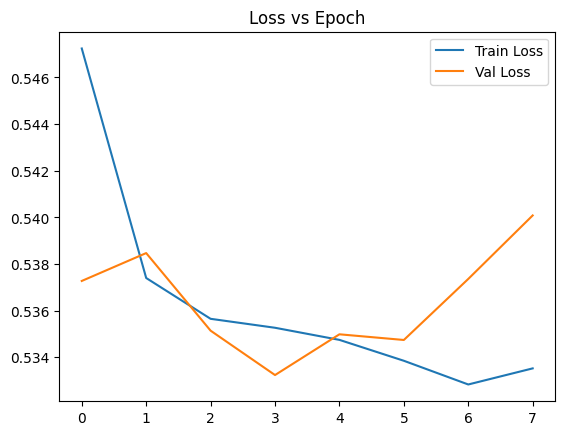

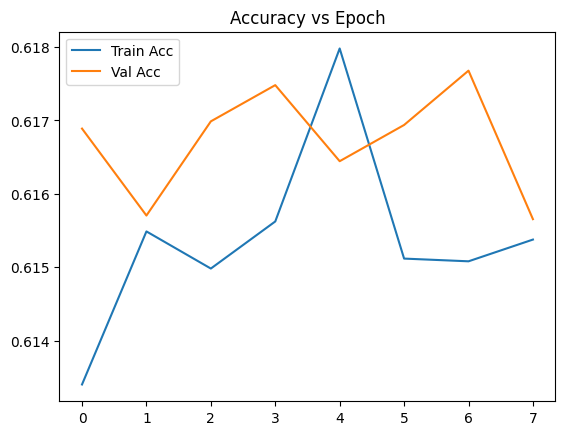

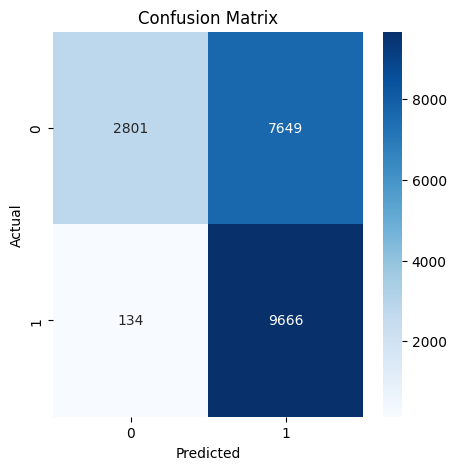

In [12]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.show()

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:
SAVE_DIR = "distilroberta_fakenews"
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "model_name": MODEL_NAME
    },
    os.path.join(SAVE_DIR, "model.pt")
)

tokenizer.save_pretrained(SAVE_DIR)

print("Model and tokenizer saved.")


Model and tokenizer saved.
